# Data assimilation using Autoencoder

###  Modules

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import models

# Observation data

In [2]:
#Loading observation data

obs_data = np.load("Data/Ferguson_fire_obs.npy")
obs_size = obs_data.shape[0]
obs_width = obs_data.shape[1]
obs_height = obs_data.shape[2]
obs_channels = 1
print("Data type: ", obs_data.dtype)
print("Shape: ", obs_data.shape)
print("Unique pixel values: ", np.unique(obs_data))
print("Batch size: ", obs_size)
print("Width: ", obs_width)
print("Height ", obs_height)

Data type:  float64
Shape:  (5, 256, 256)
Unique pixel values:  [0. 1.]
Batch size:  5
Width:  256
Height  256


### Original observation images

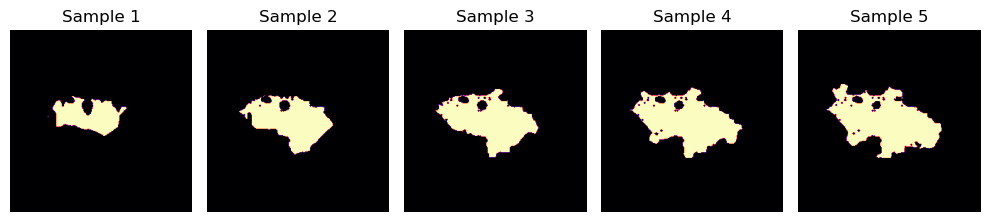

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 8))
axes = axes.ravel() 
for i in range(5):
    axes[i].imshow(obs_data[i], cmap='magma') 
    axes[i].set_title(f"Sample {i+1}") 
    axes[i].set_axis_off()
plt.tight_layout()
plt.show()

### Reshaping observation data

In [4]:
#Reshaping the dataset to create( batch_size, channel, height, width) shape for dataset.

obs_reshaped = obs_data.reshape(obs_size, obs_channels, obs_width, obs_height)
print(f"After reshaping: {obs_reshaped.shape}")

After reshaping: (5, 1, 256, 256)


# Background data

In [5]:
background_data = np.load("Data/Ferguson_fire_background.npy")
background_size = background_data.shape[0]
background_width = background_data.shape[1]
background_height = background_data.shape[2]
background_channels = 1
print("Data type: ", background_data.dtype)
print("Shape: ", background_data.shape)
print("Unique pixel values: ", np.unique(background_data))
print("Batch size: ", background_size)
print("Width: ", background_width)
print("Height ", background_height)

Data type:  int16
Shape:  (5, 256, 256)
Unique pixel values:  [0 1]
Batch size:  5
Width:  256
Height  256


### Original background images 

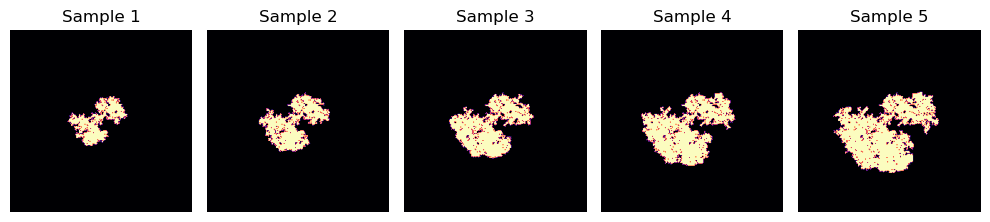

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 8))
axes = axes.ravel() 
for i in range(5):
    axes[i].imshow(background_data[i], cmap='magma') 
    axes[i].set_title(f"Sample {i+1}") 
    axes[i].set_axis_off()
plt.tight_layout()
plt.show()

### Reshaping background images

In [7]:
#Reshaping the dataset to create( batch_size, channel, height, width) shape for dataset.
background_reshaped = background_data.reshape(background_size, background_channels, background_width, background_height)
print(f"After reshaping: {background_reshaped.shape}")

After reshaping: (5, 1, 256, 256)


### Loading the autoencoder model generated in Q3

#### OneDrive link to the models for PCA and Autoencoder

[Models](https://imperiallondon-my.sharepoint.com/:f:/r/personal/gmn22_ic_ac_uk/Documents/models_bda?csf=1&web=1&e=BAVPVz)

In [8]:
model, _ = models.select_model(type=2, latent_dim=100) #Loading the same neural net architecture as previously developed.

# model = model.to(device) # If using GPU

model.load_state_dict(torch.load('convolutional_20.pth'))

<All keys matched successfully>

### Compressing observation and background data 

In [9]:
# The code below first creates a torch.tensor object from numpy array(images). 
# Then converts the data to float64. Uses this data for forward pass.
# Then detaches he gradients rom the tensors and converts it back to numpy.ndarray
# This is done for both bservation and background datasets to create compressed data for both.

obs_compressed =  model.encode(torch.from_numpy(obs_reshaped).float()).detach().numpy()
background_compressed = model.encode(torch.from_numpy(background_reshaped).float()).detach().numpy()

In [10]:
print("Shape of observation after compression: ", obs_compressed.shape)
print("Shape of background after compression: ", background_compressed.shape)

Shape of observation after compression:  (5, 100)
Shape of background after compression:  (5, 100)


### Data assimilation using Kalman Filter (BLUE)

### Defining functions 

In [11]:
from numpy.linalg import inv

def update_prediction(x, K, H, y):
    res = x + np.dot(K,(y - np.dot(H, x)))
    return res  

def KalmanGain(B, H, R):
    tempInv = inv(R + np.dot(H,np.dot(B,H.transpose())))
    res = np.dot(B,np.dot(H.transpose(),tempInv))
    return res

### Define functions for calculating the parameters for Kalman Filter

In [41]:
nNodes = 100 #Latent space dimensions
I = np.identity(nNodes)
R = I*3
# R = np.cov(observation_da_compressed.T) #or R =covariance_matrix(np.array(sensors_data).T) #Observation error covariance
H = I #Observation operator
# B = I
B = np.cov(background_compressed.T)

### Run data assimilation

In [42]:
start = time.time()

K = KalmanGain(B, H, R) 
updated_da_list = []
#Looping over every image in background dataset
for i in range(len(background_compressed)):
    #Updating the prediction for each pixel in background
    updated_da = update_prediction(background_compressed[i], K, H, obs_compressed[i]) #compute only the analysis
    #Adding it to a new assimilated array
    updated_da_list.append(updated_da)
updated_da_array = np.array(updated_da_list)
end = time.time() 

### Reconstructing/Decoding images

In [43]:
#Reconstructing images from latent space using assimilated data
# The code below first creates a torch.tensor object from numpy array(images). 
# Then converts the data to float64. Uses this data for forward pass.
# Then detaches he gradients rom the tensors and converts it back to numpy.ndarray

da_data =  model.decode(torch.from_numpy(updated_da_array).float()).detach().numpy()

### Reconstructed images vs original images

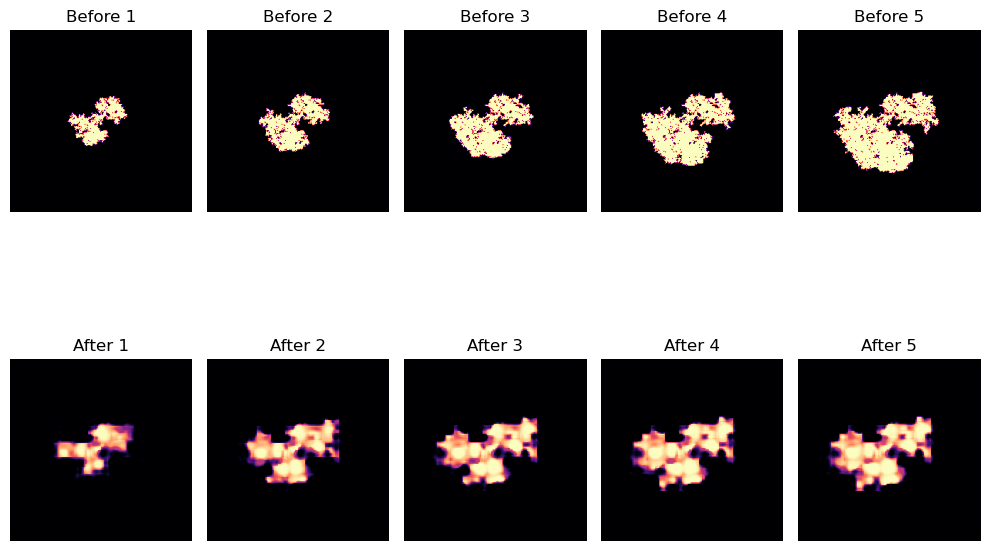

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 8))
axes = axes.ravel() 
for i in range(5):
    axes[i].imshow(background_data[i], cmap='magma') 
    axes[i].set_title(f"Before {i+1}") 
    axes[i].set_axis_off()
    
    axes[i+5].imshow(da_data[i].reshape(256, 256), cmap='magma') 
    axes[i+5].set_title(f"After {i+1}") 
    axes[i+5].set_axis_off()
plt.tight_layout()
plt.show()

### Calculating Mean Squared Error

In [45]:
time_taken = end - start

mse_before_da_physical = mean_squared_error(obs_reshaped.flatten(), background_reshaped.flatten())
mse_after_da_physical = mean_squared_error(obs_reshaped.flatten(), da_data.flatten())

mse_before_da_latent = mean_squared_error(obs_compressed, background_compressed)
mse_after_da_latent = mean_squared_error(obs_compressed, updated_da_array)

## Results

In [46]:
print("Time taken for assimilation: ", time_taken, "seconds")
print("MSE before DA in latent space: ", mse_before_da_latent)
print("MSE after DA in latent space: ", mse_after_da_latent)
print("MSE before DA in physical space: ", mse_before_da_physical)
print("MSE after DA in physical space: ", mse_after_da_physical)

Time taken for assimilation:  0.001001119613647461 seconds
MSE before DA in latent space:  81.997734
MSE after DA in latent space:  6.988599325234261
MSE before DA in physical space:  0.0772430419921875
MSE after DA in physical space:  0.05695034633496724


### Optimum parameter search


In [39]:
k=100

def optim_params(x, y):
    nNodes = k #principal components/ truncation parameter k
    I = np.identity(nNodes)
    R = I*x
    H = I 
    B = I*y
    return B, H, R

x_values = [0.00001, .0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3]
y_values = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4]


def mse_diff(x, y):
    B, H, R = optim_params(x, y)
    K = KalmanGain(B, H, R)
    updated_da_list = []
    for i in range(len(background_compressed)):
        updated_da = update_prediction(background_compressed[i], K, H, obs_compressed[i]) #compute only the analysis
        updated_da_list.append(updated_da)
    updated_da_array = np.array(updated_da_list)

    da_data =  model.decode(torch.from_numpy(updated_da_array).float()).detach().numpy()
    da_data = da_data.flatten()
    # For latent space MSE optimisation
#     mse_before_da_latent = mean_squared_error(obs_compressed, background_compressed)
#     mse_after_da_latent = mean_squared_error(obs_compressed, updated_da_array)
#     diff = mse_before_da_latent - mse_after_da_latent
    
# For physical space MSE optimisation
    mse_before_da_physical = mean_squared_error(obs_reshaped.flatten(), background_reshaped.flatten())
    mse_after_da_physical = mean_squared_error(obs_reshaped.flatten(), da_data.flatten())
    diff = mse_before_da_physical - mse_after_da_physical


    return diff

def binary_search_maximize():
    best_diff = float('-inf')
    best_x = None
    best_y = None

    for x in x_values:
        for y in y_values:
            diff = mse_diff(x, y)
            if diff > best_diff:
                best_diff = diff
                best_x = x
                best_y = y

    return best_x, best_y


In [40]:
# Binary search for optimum values
best_x, best_y = binary_search_maximize()

print('Optimum x: ', best_x)
print('Optimum y: ', best_y)
print("MSE difference for optimum values: ", mse_diff(best_x, best_y))

Optimum x:  1
Optimum y:  3
MSE difference for optimum values:  0.021343232023695057


## Analysis:
- MSE error depends not only on `Autoencoder model` but also on the values `R(observation error variance) and B(control matrix)` choosen for assimilation. Since, we don't know `how much to rely on our observation data` even though it is `satellite imagery`.
- Running a `binary search on bigger domain of R and B to maximise the MSE after and MSE before` difference can help to get the best values.

<b>Binary search for choosing the optimum parameters for KALMAN GAIN </b>

MSE latent space with B=np.cov(background_compressed.T):

 - Optimum R:  I*1e-05
 - MSE difference for optimum values:  76.93148714563843

MSE latent space:

 - Optimum R:  I*1e-05
 - Optimum B:  I*4
 - MSE difference for optimum values:  81.99773406931173

MSE physical space B =:np.cov(background_compressed.T)
    
 - Optimum R:  I*3
 - MSE difference for optimum values:  0.020292695657220257

MSE physical space:
 - Optimum R:  I*1
 - Optimum B:  I*3
 - MSE difference for optimum values:  0.021343232023695057

<b>From the observations:</b> `As the coeff in R decreases`, difference between before and after `MSE is maximised in latent space is increased`. However, `that is not the case for MSE in physical space`. MSE difference increases with increase in R. So, trust on observation/satellite data gives better MSE in latent sapce. Vise versa in physical space.

<b>- TODO: Better results can be achieved with a better autoencoder. Increasing the epochs could also increase accuracy.</b> 